In [416]:
import numpy as np
import matplotlib.pyplot as plt
from Network_bayesian import Place_net, Grid_net, Coupled_Net
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
import time
from scipy.stats import ttest_ind, norm

# 圆周距离函数
def circ_dis(phi_1, phi_2):
    dis = phi_1 - phi_2
    dis = np.where(dis > np.pi, dis - 2 * np.pi, dis)
    dis = np.where(dis < -np.pi, dis + 2 * np.pi, dis)
    return dis


In [417]:

# 默认参数
# grid spacing
lambda_1 = 3
lambda_2 = 4
lambda_3 = 5
Lambda = np.array([lambda_1, lambda_2, lambda_3])
L = lambda_1 * lambda_2 * lambda_3
# cell number
num_p = int(200)
rho_p = num_p / L
rho_g = rho_p
num_g = int(rho_g * 2 * np.pi)  # 为了让两个网络的rho相等
M = len(Lambda)
# feature space
x = np.linspace(0, L, num_p, endpoint=False)
theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)
# connection range
a_p = 0.3
a_g = a_p / Lambda * 2 * np.pi
# connection strength
J_p = 20
J_g = J_p
J_pg = J_p / 25


# divisive normalization
k_p = 20.
k_g = Lambda / 2 / np.pi * k_p
# time constants
tau_p = 1
tau_g = 2 * np.pi * tau_p / Lambda
# input_strength
alpha_p = 0.05
alpha_g = 0.05

noise_ratio = 0.007

P_CANN = Place_net(z_min=0, z_max=L, num=num_p, a_p=a_p, k=k_p, tau=tau_p, J0=J_p)
# Grid cells
G_CANNs = bm.NodeList()
for i in range(M):
    G_CANNs.append(Grid_net(z_min=0, z_max=L, num=num_g, num_hpc=num_p, L=Lambda[i], a_g=a_g[i], k_mec=k_g[i], tau=tau_g[i], J0=J_g, W0=J_pg))

Coupled_model = Coupled_Net(HPC_model=P_CANN, MEC_model_list=G_CANNs, num_module=M)

def Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p=0.05, alpha_g=0.05, Coupled_model=Coupled_model):
    Coupled_model.reset_state()
    def initial_net(Ip, Ig): 
        Coupled_model.initial(alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)

    def run_net(i, Ip, Ig): 
        Coupled_model.step_run(i, alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)
        phi_decode = Coupled_model.phase
        z_decode = Coupled_model.HPC_model.center
        rp = Coupled_model.HPC_model.r
        up = Coupled_model.HPC_model.u
        rg = bm.zeros([M, num_g])
        ug = bm.zeros([M, num_g])
        for mi in range(M):
            rg[mi, :] = Coupled_model.MEC_model_list[mi].r
            ug[mi, :] = Coupled_model.MEC_model_list[mi].u
        return z_decode, phi_decode, rp, up, rg, ug

    T_init = 500
    z0 = z_truth
    phi_0 = phi_truth
    fg = np.zeros((M, num_g))
    for i in range(M):
        dis_theta = circ_dis(theta, phi_0[i])
        fg[i, :] = np.exp(-dis_theta ** 2 / (4 * a_g[i] ** 2))
    dis_x = x - z0
    fp = np.exp(-dis_x ** 2 / (4 * a_p ** 2))
    I_place = 1 * np.repeat(fp[np.newaxis, :], T_init, axis=0)
    I_grid = 1 * np.repeat(fg[np.newaxis, :, :], T_init, axis=0)
    I_place[int(T_init / 3):, :] = 0
    I_grid[int(T_init / 3):, :, :] = 0

    bm.for_loop(initial_net, (I_place, I_grid), progress_bar=False)
    T = 5000
    indices = np.arange(T)
    I_place = alpha_p * np.repeat(Ip[np.newaxis, :], T, axis=0)
    I_grid = alpha_g * np.repeat(Ig[np.newaxis, :, :], T, axis=0)
    z_record, phi_record, rp, up, rg, ug = bm.for_loop(run_net, (indices, I_place, I_grid), progress_bar=False)

    return z_record, phi_record, up, rp, ug, rg


In [418]:
Ap = 1.0084058
Rp = 0.0128615275
Ag = 0.9814125
Rg = 0.013212965

def Grid_tuning_generation(phi_candidate, a_g, num_g):
    # phi_candidate shape: [M, n_candidate]
    n_candidate = phi_candidate.shape[-1]
    theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)  # Assuming theta is linspace
    
    # Broadcasting phi_candidate to shape [M, 1, n_candidate]
    phi_candidate_expanded = phi_candidate[:, np.newaxis, :]
    
    # Calculate dis_theta using broadcasting
    dis_theta = circ_dis(theta[:, np.newaxis], phi_candidate_expanded)
    
    # Calculate fg_prime using broadcasting
    a_g_expanded = a_g[:, np.newaxis, np.newaxis]
    fg_prime = np.exp(-dis_theta ** 2 / (4 * a_g_expanded ** 2))
    
    return fg_prime



def loglikelihood_Ig(Ig, fg, sigma_g):
    n_phi = fg.shape[-1]
    # 使用 expand_dims 将矩阵扩展为 (n, m, 1)
    Ig_expand = np.expand_dims(Ig, axis=-1)
    # 使用 tile 将矩阵沿最后一个轴重复 K 次
    Ig_expand = np.tile(Ig_expand, (1, 1, n_phi))
    log_prob = -0.5 * (Ig_expand - fg)**2 / sigma_g[:,None,None]**2 # shape [M, n_g, n_phi]
    log_prob = np.sum(log_prob, axis=1) 
    return log_prob # shape [M, n_phi]

def mapping_func(x):
    lambda_gs = Lambda
    phi = x[:,None] % Lambda *np.pi*2/Lambda
    return phi # [n_pos, M]

def prior_function(phi, z_candidates, sigma_phi):
    '''
    P(phi | x), phi shape [M], phi_x is a scalar
    '''
    phi_x = mapping_func(z_candidates) # shape [n_pos, M]
    kappa_phi = 1 / (sigma_phi)**2
    log_prob = kappa_phi*np.cos(phi-phi_x) # shape [n_pos, M]
    log_prob_z = np.sum(log_prob, axis=1)
    return log_prob_z # shape [M]

def Simplified_PSC_MAP_decoder(activation_gs, n_pos=4000, n_phi=100, M=3, 
                               alpha_p_infer=0.05, alpha_g_infer=0.05, Ap=Ap, Rp=Rp, Ag=Ag):  
    '''
    MAP: Maximum A Posteriori
    activation_gs shape [M, n_g]
    '''
    sigma_g = np.sqrt(np.sqrt(np.pi) * Ag ** 3 * rho_g * tau_g / (a_g * alpha_g_infer))
    sigma_phi = np.sqrt(8 * np.pi * Ag * tau_g / (Lambda * J_pg * rho_p * Rp))
    sigma_g_infer = sigma_g * noise_ratio
    sigma_phi_infer = sigma_phi * noise_ratio
    
    L_env = 60
    ## parameter space
    z_candidates = np.linspace(0, L_env, n_pos)
    
    phi_candidates = np.linspace(0, 2*np.pi, n_phi, endpoint=False)
    phi_candidates_modules = np.tile(phi_candidates[:, np.newaxis], (1, M))
    phi_candidates_modules = phi_candidates_modules.T
    fg_modules = Grid_tuning_generation(phi_candidates_modules,a_g,num_g) # shape [M, n_g, n_phi]

    log_likelihood_fr = loglikelihood_Ig(activation_gs, fg_modules, sigma_g=sigma_g_infer) # shape [M, n_phi]
    phi_decode_index = np.argmax(log_likelihood_fr, axis=1)

    phi_decode = phi_candidates[phi_decode_index]
    # Second step: decode z
    prior = prior_function(phi_decode, z_candidates, sigma_phi=sigma_phi_infer)
    # plt.plot(prior)
    z_est_index = np.argmax(prior)
    z_decode = z_candidates[z_est_index]
    return z_decode, phi_decode

In [419]:


sigma_g = np.sqrt(np.sqrt(np.pi)*Ag**3*rho_g*tau_g/(a_g*alpha_g)) * 0.01
sigma_phi = np.sqrt(8*np.pi*Ag*tau_g/(Lambda*J_pg*rho_p*Rp)) * 0.01
sigma_p = np.sqrt(np.sqrt(np.pi)*Ap**3*rho_p*tau_p/(a_p*alpha_p)) * 0.01
print(sigma_g, sigma_p, sigma_phi)

[0.19295613 0.19295613 0.19295613] 0.2009713795376621 [0.22407002 0.16805252 0.13444201]


In [420]:
neural_noise_sigma = 0.2
z_truth = 30
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
sigma_phi_noise = np.array([31.7,23.8,19])*neural_noise_sigma/20
print(sigma_phi_noise)
z_truth = 30
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
z_e = z_truth
psi = phi_truth + sigma_phi_noise * np.random.randn(M)

Ig = np.zeros((M, num_g))
for j in range(M):
    dis_theta = circ_dis(theta, psi[j])
    Ig[j, :] = np.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2)) + neural_noise_sigma * np.random.randn(num_g)
dis_x = x - z_e
Ip = np.exp(-dis_x ** 2 / (4 * a_p ** 2)) + neural_noise_sigma * np.random.randn(num_p) 
z_decode, phi_decode = Simplified_PSC_MAP_decoder(activation_gs=Ig, n_pos=4000, n_phi=100, M=3)
print('z_decode:', z_decode)

[0.317 0.238 0.19 ]
z_decode: 29.88747186796699


In [421]:

# 主程序
neural_noise_sigma = 0.4
trial_num = 500
z_truth = 30
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
sigma_phi = np.array([31.7,23.8,19])*neural_noise_sigma/20

z_decode_MAP = np.zeros(trial_num)
z_decode_net = np.zeros(trial_num)

start_time = time.time()  # 记录开始时间

for i in range(trial_num):
    z_truth = 30
    phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
    z_e = z_truth
    psi = phi_truth + sigma_phi * np.random.randn(M)
    Ig = np.zeros((M, num_g))
    for j in range(M):
        dis_theta = circ_dis(theta, psi[j])
        Ig[j, :] = np.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2)) + neural_noise_sigma * np.random.randn(num_g)
    dis_x = x - z_e
    Ip = 0*(np.exp(-dis_x ** 2 / (4 * a_p ** 2)) + neural_noise_sigma * np.random.randn(num_p) )
    z_decode_n, _, up, rp, ug, rg = Net_decoding(z_truth, phi_truth, Ip, Ig)

    max_up = np.max(up, axis=1)
    max_rp = np.max(rp, axis=1)
    Ap = np.max(max_up[-1])
    Rp = np.max(max_rp[-1])
    Ag = np.zeros(M,)
    Rg = np.zeros(M,)
    for mi in range(M):
        max_ug = np.max(ug[:, mi, :], axis=1)
        max_rg = np.max(rg[:, mi, :], axis=1)
        Ag[mi] = np.max(max_ug[-1])
        Rg[mi] = np.max(max_rg[-1])

    z_decode_m, _ = Simplified_PSC_MAP_decoder(activation_gs=Ig, Ap=Ap, Rp=Rp, Ag=Ag)

    z_decode_MAP[i] = z_decode_m
    z_decode_net[i] = z_decode_n[-1]
    if i % 5 == 0:
        print(f"Progress: {i/trial_num*100:.2f}%")

end_time = time.time()  # 记录结束时间
print(f"Total runtime: {end_time - start_time:.2f} seconds")


# 保存数据为npz文件
np.savez('results/cth/MAP_vs_Net_distribution.npz', z_decode_net=z_decode_net, z_decode_MAP=z_decode_MAP)



Progress: 0.00%
Progress: 1.00%
Progress: 2.00%
Progress: 3.00%
Progress: 4.00%
Progress: 5.00%
Progress: 6.00%
Progress: 7.00%
Progress: 8.00%
Progress: 9.00%
Progress: 10.00%
Progress: 11.00%
Progress: 12.00%
Progress: 13.00%
Progress: 14.00%
Progress: 15.00%
Progress: 16.00%
Progress: 17.00%
Progress: 18.00%
Progress: 19.00%
Progress: 20.00%
Progress: 21.00%
Progress: 22.00%
Progress: 23.00%
Progress: 24.00%
Progress: 25.00%
Progress: 26.00%
Progress: 27.00%
Progress: 28.00%
Progress: 29.00%
Progress: 30.00%
Progress: 31.00%
Progress: 32.00%
Progress: 33.00%
Progress: 34.00%
Progress: 35.00%
Progress: 36.00%
Progress: 37.00%
Progress: 38.00%
Progress: 39.00%
Progress: 40.00%
Progress: 41.00%
Progress: 42.00%
Progress: 43.00%
Progress: 44.00%
Progress: 45.00%
Progress: 46.00%
Progress: 47.00%
Progress: 48.00%
Progress: 49.00%
Progress: 50.00%
Progress: 51.00%
Progress: 52.00%
Progress: 53.00%
Progress: 54.00%
Progress: 55.00%
Progress: 56.00%
Progress: 57.00%
Progress: 58.00%
Progres

Net decoding error: 0.20105807710786114
MAP decoding error: 13.013699945379102


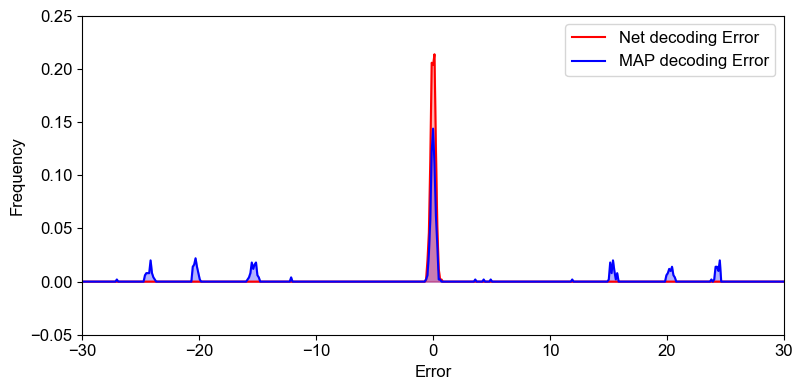

In [443]:

z_decode_all = np.concatenate([z_decode_net, z_decode_MAP])
min_z = np.min(z_decode_all)
max_z = np.max(z_decode_all)

# 设置字体
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})
error_Net = z_decode_net-z_truth
error_MAP = z_decode_MAP-z_truth
print('Net decoding error:', np.std(error_Net))
print('MAP decoding error:', np.std(error_MAP))

# Compute the histogram for the PSC and LSC errors
counts_psc, bin_edges_psc = np.histogram(error_MAP, bins=np.linspace(-30,30,500))
counts_lsc, bin_edges_lsc = np.histogram(error_Net, bins=np.linspace(-30,30,500))

# Calculate the bin centers
bin_centers_psc = (bin_edges_psc[:-1] + bin_edges_psc[1:]) / 2
bin_centers_lsc = (bin_edges_lsc[:-1] + bin_edges_lsc[1:]) / 2

# Remove zero points
# nonzero_indices_lsc = counts_lsc > 0
# bin_centers_lsc = bin_centers_lsc[nonzero_indices_lsc]
# counts_lsc = counts_lsc[nonzero_indices_lsc]

# Plot the histogram with non-zero points only
plt.figure(figsize=(8, 4))
plt.plot(bin_centers_lsc, counts_lsc/np.sum(counts_lsc), label='Net decoding Error', color='red')
plt.plot(bin_centers_psc, counts_psc/np.sum(counts_psc), label='MAP decoding Error', color='blue')

plt.fill_between(bin_centers_psc, counts_psc/np.sum(counts_psc), color='blue', alpha=0.3)
plt.fill_between(bin_centers_lsc, counts_lsc/np.sum(counts_lsc), color='red', alpha=0.3)

plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.ylim(-0.05,0.25)
plt.xlim(-30,30)
plt.savefig('figures_cth/MAP_vs_NET.pdf')
plt.show()


